In classical linear regression models, one of the assumptions we make is that the variance of disturbance(error) term is constant and this assumption is known as ***Homoscedasticity*** [ie. equal(homo) spread(scedasticity)].  

If $ \epsilon $ is the error term, then $ E(\epsilon_i^2) = \sigma^2$  where $\sigma$ is the standard deviation.

 The violation of this assumption is ***Heteroscedasticity***.  
 Some of the causes of Heteroscedasticity include,
*   Presence of outliers in the observations (stock prices)
*   Incorrect transformation of data used for the regression model
*   When regression model is itself wrongly specified
*   Skewness in distribution of regressor variables. For example, economic variables like income are unevenly distibuted  

In the presence of heteroscedasticity, the estimators are no longer efficient and hypothesis tests(like t-test, F-test) become invalid. So, it is essential to detect heteroscedasticity and adjust for it.






In [1]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

%matplotlib inline


Firstly, let's create a heteroscedastic dataset and plot it to see how it looks like!

In [31]:
#setting sample size
size = 200

#generating a random sample for the independent variable x
x = np.sort(np.random.uniform(low = 0, high = 50, size = size))

#generating the error term which increases with increasing values of x
u = 1.5* np.random.rand(size) * x

#generating the dependent variable y using a arbitrary expression
y = 5 + 1.1*x + u

Text(0, 0.5, 'y')

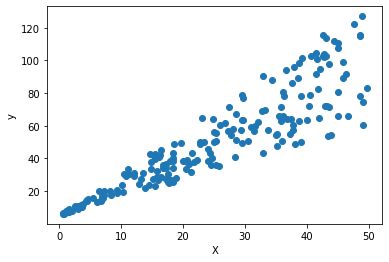

In [32]:
#ploting the data
plt.scatter(x,y)
plt.xlabel('X')
plt.ylabel('y')

We can clearly see that the y value varies a lot for larger values of x  
Although we now detected heteroscedasticity by visualising the data, there are some standard statistical tests to detect heteroscedasticity.  
We will now use the functions from [statsmodels](https://www.statsmodels.org/dev/diagnostic.html) library to perform *Breusch-Pagan test* and *Goldfeld-Quandt test*.

In [33]:
'''Breusch-Pagan test'''
#performing OLS fit as residual values are needed for Breusch-Pagan test
model = sm.OLS(y,x).fit()

#extracting residual values from the fitted model
residuals = model.resid

#performing Breusch-Pagan test
bp_test = het_breuschpagan(residuals, x.reshape(-1,1))

#zipping and printing the results 
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))


{'LM Statistic': 104.8034118982716, 'LM-Test p-value': nan, 'F-Statistic': 219.08221065096546, 'F-Test p-value': 6.466914567750757e-34}


We have got two test statistics and the p-values (F-test is widely used but both are basically equivalent).  
If p-value is less than 0.05, we reject the null hypothesis of homoscedasticity (i.e. it indicates heteroscedasticity). As we get both p-values <0.05, this model is heteroscedastic.


In [34]:
'''Goldfeld-Quandt test'''
gq_test = het_goldfeldquandt(y,x.reshape(-1,1))
print("F-Statistic: ",gq_test[0],", p-value: " ,gq_test[1])

F-Statistic:  6.503489959977403 , p-value:  1.363497447803045e-18


Goldfeld-Quandt test verifies if the residual variance is same in two sample subsets. So, as with the previous test we reject the null hypothesis as p-value comes out to be less than 0.05.  

Now that we have detected heteroscedasticity, we have to deal with it!  

We can dampen the effect of heteroscedasticity to some extent by applying log transformation to 'y'. In the below plot, note that the error becomes almost constant terminally.



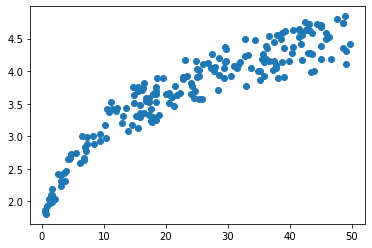

In [48]:
#Log-transforming y 
plt.scatter(x,np.log(y))

But in some cases heteroscedasticity may still persist and so,we cannot fit models which assume homoscedaticity.  
There are some generalized regression models like *Weighted Least Squares*(WLS) or *Generalized Least Squares*(GLS) - which don't assume homoscedastic variance.  

Using WLS, the weight for each datapoint can be scaled inversely with the variance. But then we have to model variance as a function of x!      
For the current dataset, we know that variance increases for higher values of x. So we can define the weights as inverse of x values.




In [49]:
'''Fitting a WLS model'''
#Performing WLS fit with weights varying as inverse of x
mod_wls = sm.WLS(y,x,weights = 1./x).fit()

Now let's plot the WLS and OLS results to see the difference

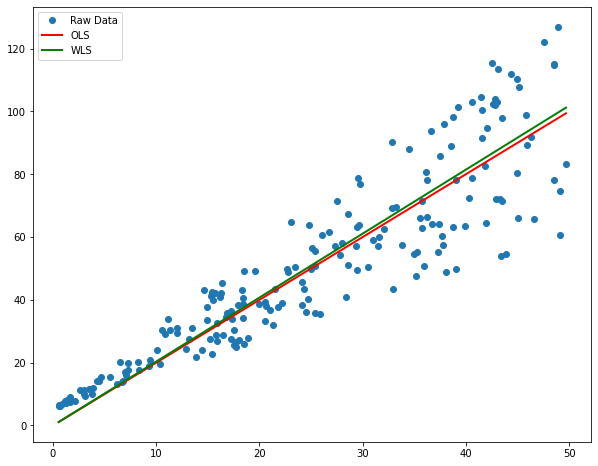

In [50]:
#plotting the regression lines
plt.subplots(figsize=(10,8))
plt.plot(x,y,'o',label = "Raw Data")
plt.plot(x,model.fittedvalues,'r',label = "OLS",linewidth = 2)
plt.plot(x,mod_wls.fittedvalues,'g',label = "WLS",linewidth = 2)
plt.legend()

Although there's only a slight difference here, in real world applications a small change in slope might make a lot of impact.